In [195]:
import pandas as pd
import numpy as np
import re
import pickle
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from gensim.models import KeyedVectors, Word2Vec
from pathlib import Path
from datetime import datetime
from collections import Counter

In [196]:
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10
sns.set_style('whitegrid')

try:
    russian_stopwords = stopwords.words('russian')
except:
    nltk.download('stopwords')
    russian_stopwords = stopwords.words('russian')

In [197]:
train_bodies = pd.read_csv('./data/train_bodies.csv')
test_bodies = pd.read_csv('./data/test_bodies.csv')

train_stances = pd.read_csv('./data/train_stances.csv')
test_stances = pd.read_csv('./data/test_stances_unlebeledb.csv') 

# Проведем предобработку данных

## Объединим данные

In [198]:
train_data = train_stances.merge(train_bodies, on='Body ID', how='left')
test_data = test_stances.merge(test_bodies, on='Body ID', how='left')

## Проведем предобработку русского языка

In [199]:
def preprocess_text(text):
    if not isinstance(text, str) or len(text) == 0:
        return ""
    
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'\S+@\S+', '', text)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^а-яё\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    
    words = text.split()
    words = [word for word in words if word not in russian_stopwords and len(word) > 2]
    
    return ' '.join(words)

## Обработка заголовков и текстов

In [200]:
train_data['headline_clean'] = train_data['Headline'].apply(preprocess_text)
train_data['body_clean'] = train_data['articleBody'].apply(preprocess_text)

test_data['headline_clean'] = test_data['Headline'].apply(preprocess_text)
test_data['body_clean'] = test_data['articleBody'].apply(preprocess_text)


## Создадим комбинированные признаки (заголовок + начало текста)

In [201]:
def combine_features(row):
    headline = row['headline_clean']
    body_words = row['body_clean'].split()
    body = ' '.join(body_words)
    return f"{headline} {body}"

In [202]:
train_data['combined_text'] = train_data.apply(combine_features, axis=1)
test_data['combined_text'] = test_data.apply(combine_features, axis=1)

In [203]:
train_data = train_data[train_data['combined_text'].str.len() > 10].reset_index(drop=True)
test_data = test_data[test_data['combined_text'].str.len() > 10].reset_index(drop=True)

In [204]:
train_data['text_length'] = train_data['combined_text'].str.split().str.len()
print(f"\nСтатистика длины комбинированных текстов (в словах):")
print(train_data['text_length'].describe())

train_data_tf = train_data


Статистика длины комбинированных текстов (в словах):
count    4408.000000
mean      136.134528
std        69.050534
min         9.000000
25%       101.000000
50%       126.000000
75%       153.000000
max      1084.000000
Name: text_length, dtype: float64


## Подготовим целевую переменную
---
где:
* Реальная новость - 1
* Фейк - 0

In [205]:
label_mapping = {'agree': 1, 'disagree': 0}

train_data['label'] = train_data['Stance'].map(label_mapping)
train_data.head(3)

,Unnamed: 0_x,Body ID,Headline,Stance,Headline1,Headline2,Unnamed: 0_y,articleBody,articleBody1,articleBody2,headline_clean,body_clean,combined_text,text_length,label
0,0,1,"['российский', 'бюджет', 'марте', 'недополучил...",agree,российский бюджет в марте недополучил более 30...,российский бюджет март недополучать миллиард р...,0,Разница между ожидаемыми по итогам марта нефте...,разница ожидаемыми итогам марта нефтегазовыми ...,разница ожидать итог март нефтегазовый доход ф...,российский бюджет марте недополучил миллиардов...,разница ожидаемыми итогам марта нефтегазовыми ...,российский бюджет марте недополучил миллиардов...,73,1
1,1,2,"['банк', 'россии', 'решил', 'снизить', 'ключев...",agree,банк россии решил снизить ключевую ставку с 20...,банк россия решать снижать ключевой ставка,1,Совет директоров Банка России решил снизить кл...,совет директоров банка россии решил снизить кл...,совет директор банк россия решать снижать ключ...,банк россии решил снизить ключевую ставку,совет директоров банка россии решил снизить кл...,банк россии решил снизить ключевую ставку сове...,57,1
2,2,3,"['мыс', 'идокопас', 'нато', 'назвали', 'первую...",disagree,мыс идокопас в нато назвали первую цель для н...,мыс идокопас нато называть первый цель начало ...,2,В НАТО составили наступательный план действий ...,нато составили наступательный план действий за...,нато составлять наступательный план действие з...,мыс идокопас нато назвали первую цель начала п...,нато составили наступательный план действий за...,мыс идокопас нато назвали первую цель начала п...,100,0


In [206]:
train_data_tf['label'] = train_data_tf['Stance'].map(label_mapping)
train_data_tf.head(3)

,Unnamed: 0_x,Body ID,Headline,Stance,Headline1,Headline2,Unnamed: 0_y,articleBody,articleBody1,articleBody2,headline_clean,body_clean,combined_text,text_length,label
0,0,1,"['российский', 'бюджет', 'марте', 'недополучил...",agree,российский бюджет в марте недополучил более 30...,российский бюджет март недополучать миллиард р...,0,Разница между ожидаемыми по итогам марта нефте...,разница ожидаемыми итогам марта нефтегазовыми ...,разница ожидать итог март нефтегазовый доход ф...,российский бюджет марте недополучил миллиардов...,разница ожидаемыми итогам марта нефтегазовыми ...,российский бюджет марте недополучил миллиардов...,73,1
1,1,2,"['банк', 'россии', 'решил', 'снизить', 'ключев...",agree,банк россии решил снизить ключевую ставку с 20...,банк россия решать снижать ключевой ставка,1,Совет директоров Банка России решил снизить кл...,совет директоров банка россии решил снизить кл...,совет директор банк россия решать снижать ключ...,банк россии решил снизить ключевую ставку,совет директоров банка россии решил снизить кл...,банк россии решил снизить ключевую ставку сове...,57,1
2,2,3,"['мыс', 'идокопас', 'нато', 'назвали', 'первую...",disagree,мыс идокопас в нато назвали первую цель для н...,мыс идокопас нато называть первый цель начало ...,2,В НАТО составили наступательный план действий ...,нато составили наступательный план действий за...,нато составлять наступательный план действие з...,мыс идокопас нато назвали первую цель начала п...,нато составили наступательный план действий за...,мыс идокопас нато назвали первую цель начала п...,100,0


# Word2Vec

## Загрузим эмбеддинги

In [207]:
sentences = [text.split() for text in train_data['body_clean']] + [text.split() for text in train_data['headline_clean']]
w2v = Word2Vec(sentences, vector_size=300, window=3, min_count=3, sg=1, workers=4, epochs=10)
kv = w2v.wv

## Функция для получения усреднённого вектора

In [208]:
def doc_vector(tokens, kv_model):
    vecs = [kv_model[w] for w in tokens if w in kv_model]
    if not vecs:
        return np.zeros(kv_model.vector_size, dtype=np.float32)
    return np.vstack(vecs).mean(axis=0)

## Соберем признаки: headline_vec, body_vec, косинусная близость

In [209]:
def cosine(u, v):
    nu, nv = np.linalg.norm(u), np.linalg.norm(v)
    if nu == 0 or nv == 0:
        return 0.0
    return float(np.dot(u, v) / (nu * nv))

def jaccard(a_tokens, b_tokens):
    A, B = set(a_tokens), set(b_tokens)
    if not A and not B:
        return 0.0
    return len(A & B) / max(1, len(A | B))

def overlap_ratio(a_tokens, b_tokens):
    A, B = set(a_tokens), set(b_tokens)
    if not A:
        return 0.0
    return len(A & B) / len(A)

def elementwise_stats(h_vec, b_vec):
    diff = np.abs(h_vec - b_vec)              
    prod = h_vec * b_vec                      
    l2 = np.linalg.norm(h_vec - b_vec)        
    return diff, prod, l2

def build_features(df, kv, max_len=150):
    H, B, COS, JAC, OVR, L2, DIFF, PROD = [], [], [], [], [], [], [], []
    for i, row in df.iterrows():
        htoks = row['headline_clean'].split()[:max_len]
        btoks = row['body_clean'].split()[:max_len]

        h_vec = doc_vector(htoks, kv)
        b_vec = doc_vector(btoks, kv)

        H.append(h_vec); B.append(b_vec)

        COS.append(cosine(h_vec, b_vec))
        JAC.append(jaccard(htoks, btoks))
        OVR.append(overlap_ratio(htoks, btoks))

        diff, prod, l2 = elementwise_stats(h_vec, b_vec)
        DIFF.append(diff); PROD.append(prod); L2.append(l2)

    H = np.vstack(H); B = np.vstack(B)
    COS = np.array(COS).reshape(-1, 1)
    JAC = np.array(JAC).reshape(-1, 1)
    OVR = np.array(OVR).reshape(-1, 1)
    L2  = np.array(L2).reshape(-1, 1)
    DIFF = np.vstack(DIFF)     # размер N, d
    PROD = np.vstack(PROD)     # размер N, d

    X = np.hstack([H, B, DIFF, PROD, COS, JAC, OVR, L2])
    return X

## Подготовка X и y

In [210]:
X = build_features(train_data, kv)
y = train_data['label'].values

## Разделим

In [211]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

## Обучим модель логистической регрессии и прогоним по метрикам

In [212]:
# clf = LogisticRegression(max_iter=2000, C=2.0, solver='liblinear', class_weight='balanced')
# clf.fit(X_train, y_train)
# y_pred = clf.predict(X_val)

# print(f"Val Accuracy: {accuracy_score(y_val, y_pred):.4f}")
# print(f"Val F1: {f1_score(y_val, y_pred):.4f}")
# print(classification_report(y_val, y_pred, digits=4))

In [213]:
models = {
    'LogisticRegression': LogisticRegression(max_iter=2000, C=2.0, solver='liblinear', class_weight='balanced'),
    'RandomForest': RandomForestClassifier(n_estimators=100, max_depth=30, random_state=42, n_jobs=-1, class_weight='balanced')
}

Path("models").mkdir(parents=True, exist_ok=True)

In [ ]:

results = {}

for name, model in models.items():
    print(f"\n--- {name} ---")
    model.fit(X_train, y_train)  # X_train = word2vec-фичи
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    train_acc = accuracy_score(y_train, y_train_pred)
    val_acc = accuracy_score(y_val, y_val_pred)
    val_f1 = f1_score(y_val, y_val_pred, average='weighted')
    print(f"  Train Accuracy: {train_acc:.4f}")
    print(f"  Val Accuracy:   {val_acc:.4f}")
    print(f"  Val F1-Score:   {val_f1:.4f}")
    print(f"\n  Classification Report (Validation):")
    print(classification_report(y_val, y_val_pred,
                               target_names=['Фейк (disagree)', 'Реальная (agree)'],
                               digits=4))
    model_name = name.lower().replace(" ", "_")
    with open(f"models/{model_name}_model.pkl", "wb") as f:
        pickle.dump(model, f)
    results[name] = {
        'model': model,
        'train_acc': train_acc,
        'val_acc': val_acc,
        'val_f1': val_f1,
        'predictions': y_val_pred
    }
# Эмбеддинги
kv.save("models/w2v_vectors.kv")


--- LogisticRegression ---
  Train Accuracy: 0.9370
  Val Accuracy:   0.9229
  Val F1-Score:   0.9229

  Classification Report (Validation):
                  precision    recall  f1-score   support

 Фейк (disagree)     0.9178    0.9302    0.9239       444
Реальная (agree)     0.9282    0.9155    0.9218       438

        accuracy                         0.9229       882
       macro avg     0.9230    0.9229    0.9229       882
    weighted avg     0.9230    0.9229    0.9229       882


--- RandomForest ---
  Train Accuracy: 1.0000
  Val Accuracy:   0.9184
  Val F1-Score:   0.9183

  Classification Report (Validation):
                  precision    recall  f1-score   support

 Фейк (disagree)     0.9408    0.8941    0.9169       444
Реальная (agree)     0.8978    0.9429    0.9198       438

        accuracy                         0.9184       882
       macro avg     0.9193    0.9185    0.9183       882
    weighted avg     0.9194    0.9184    0.9183       882

✓ Все модели сохране

## Сохраним модель, эмбеддинги и метаданные

In [215]:
# # Модель
# Path("models").mkdir(parents=True, exist_ok=True)
# with open("models/fake_news_w2v_lr.pkl", "wb") as f:
#     pickle.dump(clf, f)

# # Эмбеддинги
# kv.save("models/w2v_vectors.kv")

# # Метаданные
# metrics = {
#     "best_model_name": "LogisticRegression+W2V",
#     "val_accuracy": float(accuracy_score(y_val, y_pred)),
#     "val_f1": float(f1_score(y_val, y_pred)),
#     "vector_size": kv.vector_size
# }
# with open("models/metrics.pkl", "wb") as f:
#     pickle.dump(metrics, f)

# TF-IDF

## Разделим данные

In [216]:
X = train_data_tf['combined_text']
y = train_data_tf['label']

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [217]:
print(f"\nРаспределение классов в train:")
print(y_train.value_counts())
print(f"\nРаспределение классов в validation:")
print(y_val.value_counts())


Распределение классов в train:
label
0    1777
1    1749
Name: count, dtype: int64

Распределение классов в validation:
label
0    444
1    438
Name: count, dtype: int64


## Векторизация

In [218]:
vectorizer = TfidfVectorizer(
    max_features=8000,
    ngram_range=(1, 2),  
    min_df=3,
    max_df=0.85,
    sublinear_tf=True
)

X_train_vec = vectorizer.fit_transform(X_train)
X_val_vec = vectorizer.transform(X_val)

print(f"✓ Размерность векторов: {X_train_vec.shape[1]} признаков")
print(f"✓ Разреженность: {(1 - X_train_vec.nnz / (X_train_vec.shape[0] * X_train_vec.shape[1])) * 100:.2f}%")

✓ Размерность векторов: 8000 признаков
✓ Разреженность: 98.97%


## Обучим 3 модели и в последствии выберем лучшую
---
* Logistic Regression
* Naive Bayes
* Random Forest

In [219]:
models = {
    'Logistic Regression': LogisticRegression(
        max_iter=1000,
        C=1,
        random_state=42,
        class_weight='balanced'
    ),
    'Naive Bayes': MultinomialNB(alpha=0.1),
    'Random Forest': RandomForestClassifier(
        n_estimators=100,
        max_depth=30,
        random_state=42,
        n_jobs=-1,
        class_weight='balanced'
    )
}

In [220]:
results = {}

for name, model in models.items():
    print(f"\n--- {name} ---")

    print("  Обучение модели...")
    model.fit(X_train_vec, y_train)
    
    y_train_pred = model.predict(X_train_vec)
    y_val_pred = model.predict(X_val_vec)
    
    # Метрики
    train_acc = accuracy_score(y_train, y_train_pred)
    val_acc = accuracy_score(y_val, y_val_pred)
    val_f1 = f1_score(y_val, y_val_pred, average='weighted')
    
    print(f"  Train Accuracy: {train_acc:.4f}")
    print(f"  Val Accuracy:   {val_acc:.4f}")
    print(f"  Val F1-Score:   {val_f1:.4f}")
    
    print(f"\n  Classification Report (Validation):")
    print(classification_report(y_val, y_val_pred,
                                target_names=['Фейк (disagree)', 'Реальная (agree)'],
                                digits=4))
    
    results[name] = {
        'model': model,
        'train_acc': train_acc,
        'val_acc': val_acc,
        'val_f1': val_f1,
        'predictions': y_val_pred
    }


--- Logistic Regression ---
  Обучение модели...
  Train Accuracy: 0.9875
  Val Accuracy:   0.9546
  Val F1-Score:   0.9546

  Classification Report (Validation):
                  precision    recall  f1-score   support

 Фейк (disagree)     0.9391    0.9730    0.9558       444
Реальная (agree)     0.9716    0.9361    0.9535       438

        accuracy                         0.9546       882
       macro avg     0.9553    0.9545    0.9546       882
    weighted avg     0.9552    0.9546    0.9546       882


--- Naive Bayes ---
  Обучение модели...
  Train Accuracy: 0.9645
  Val Accuracy:   0.9388
  Val F1-Score:   0.9387

  Classification Report (Validation):
                  precision    recall  f1-score   support

 Фейк (disagree)     0.9185    0.9640    0.9407       444
Реальная (agree)     0.9615    0.9132    0.9368       438

        accuracy                         0.9388       882
       macro avg     0.9400    0.9386    0.9387       882
    weighted avg     0.9399    0.9388

## Проверим на метриках

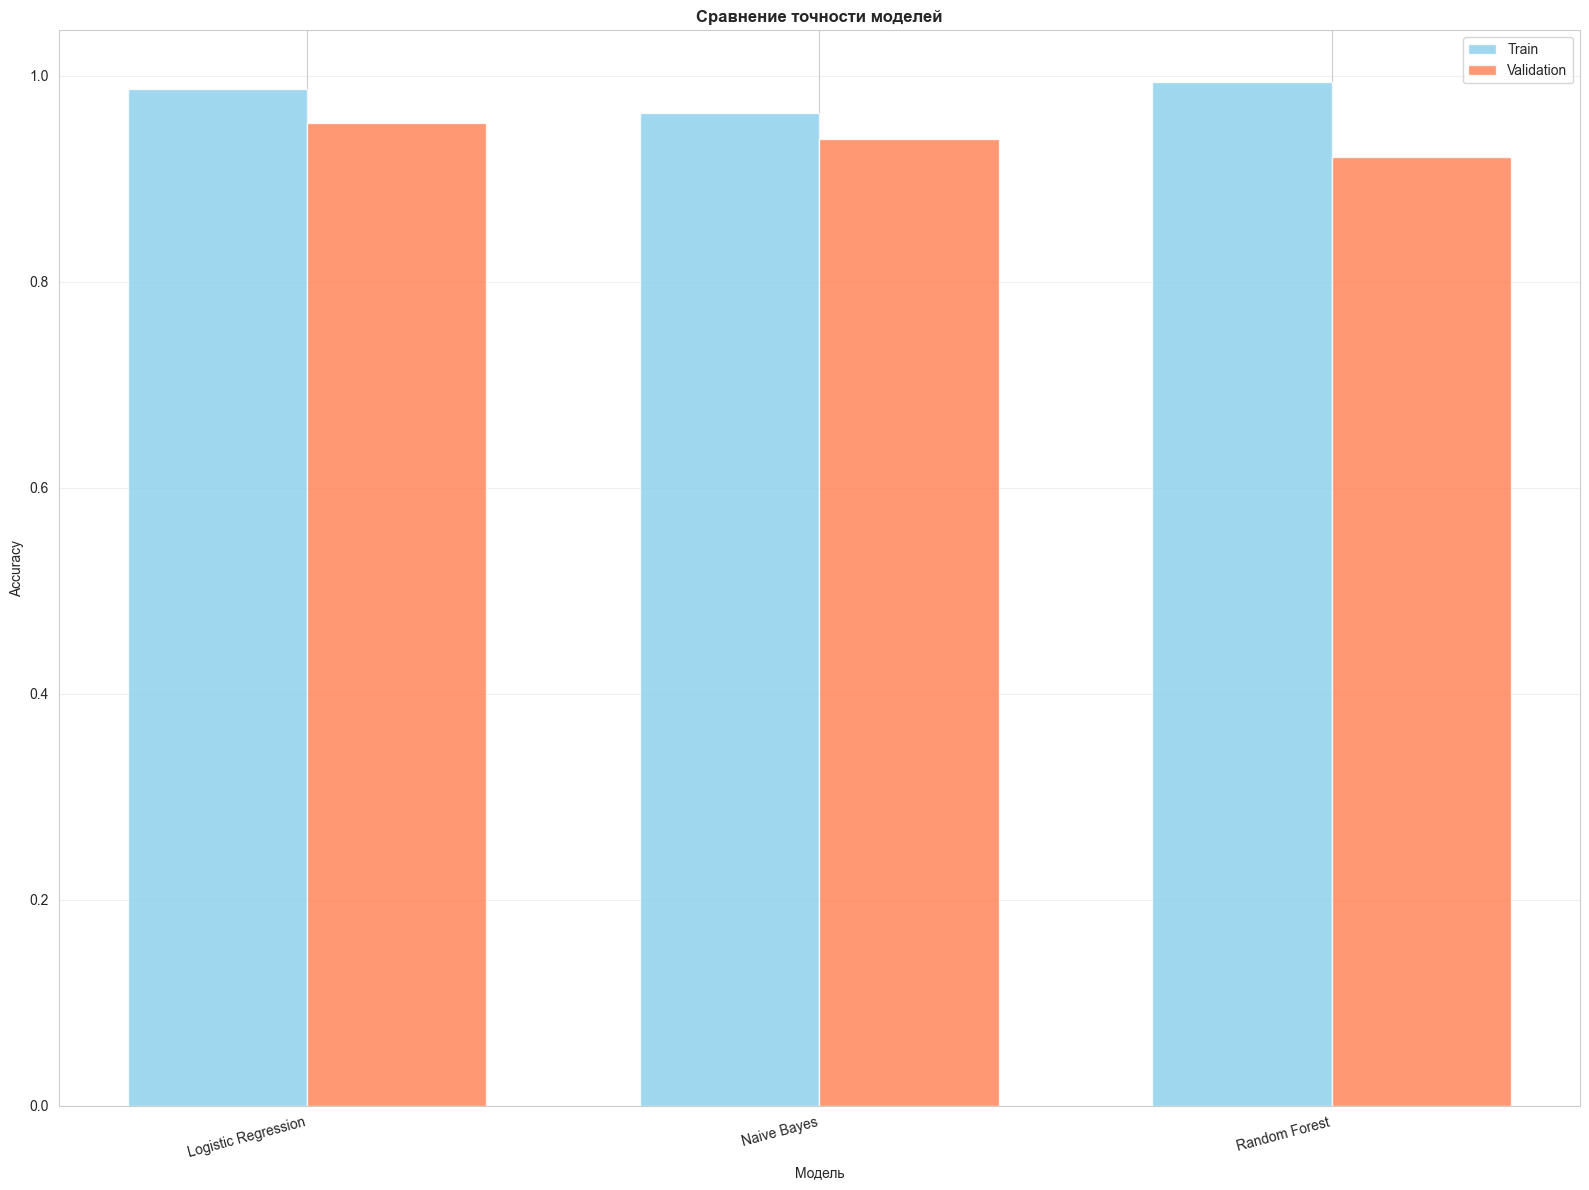

In [221]:
fig, ax = plt.subplots(1, 1, figsize=(16, 12))

model_names = list(results.keys())
train_accs = [results[name]['train_acc'] for name in model_names]
val_accs = [results[name]['val_acc'] for name in model_names]

x = np.arange(len(model_names))
width = 0.35

ax.bar(x - width/2, train_accs, width, label='Train', alpha=0.8, color='skyblue')
ax.bar(x + width/2, val_accs, width, label='Validation', alpha=0.8, color='coral')
ax.set_xlabel('Модель')
ax.set_ylabel('Accuracy')
ax.set_title('Сравнение точности моделей', fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(model_names, rotation=15, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('./assets/models_scores.png', dpi=300)


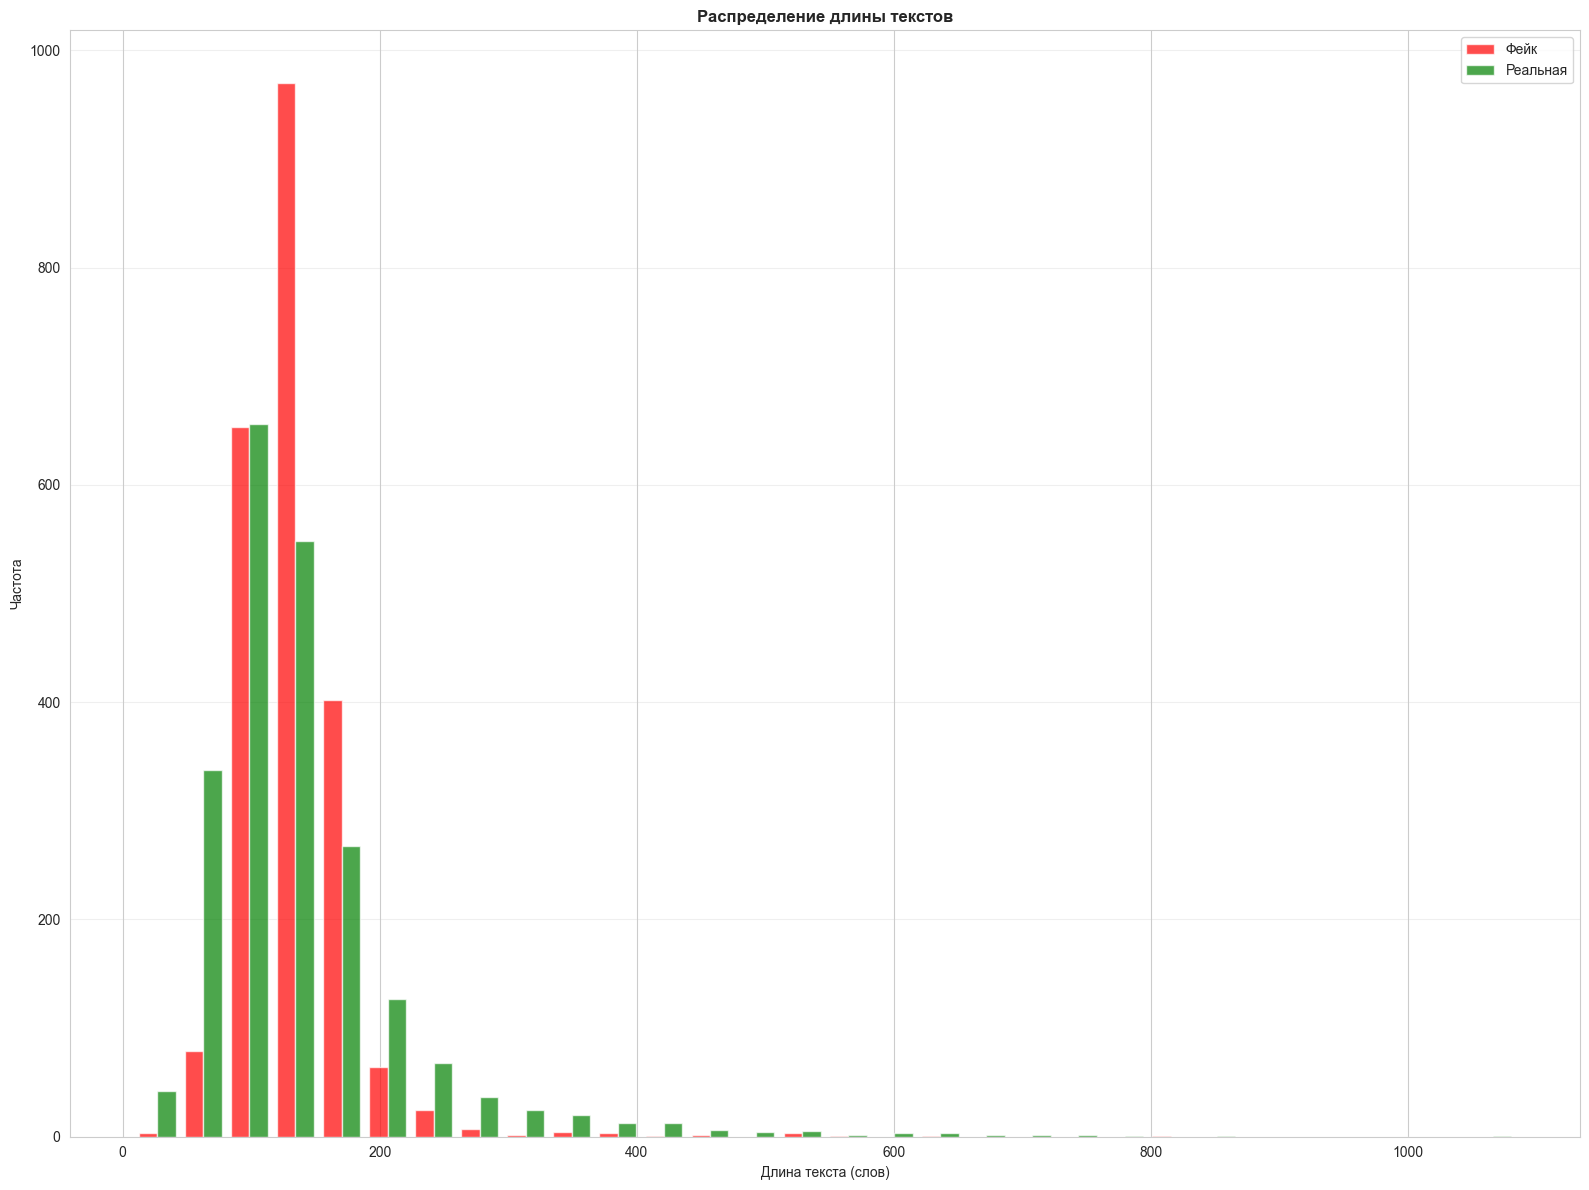

In [222]:
fig, ax = plt.subplots(1, 1, figsize=(16, 12))

ax.hist(
    [train_data_tf[train_data_tf['label']==0]['text_length'],
     train_data_tf[train_data_tf['label']==1]['text_length']],
    bins=30, label=['Фейк', 'Реальная'], alpha=0.7, color=['red', 'green']
)
ax.set_xlabel('Длина текста (слов)')
ax.set_ylabel('Частота')
ax.set_title('Распределение длины текстов', fontweight='bold')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('./assets/text_lenght.png', dpi=300)

## Сохраним модели

In [223]:
# best_model_name_tf = max(results, key=lambda x: results[x]['val_acc'])
# best_predictions = results[best_model_name_tf]['predictions']

# best_model = results[best_model_name_tf]['model']
# best_acc = results[best_model_name_tf]['val_acc']
# best_f1 = results[best_model_name_tf]['val_f1']

# print(f"Лучшая модель: {best_model_name_tf}")
# print(f"Validation Accuracy: {best_acc:.4f}")
# print(f"Validation F1-Score: {best_f1:.4f}")

# with open('./models/fake_news_detector_tf.pkl', 'wb') as f:
#     pickle.dump(best_model, f)

# with open('./models/tfidf_vectorizer_tf.pkl', 'wb') as f:
#     pickle.dump(vectorizer, f)

# with open('./models/label_mapping_tf.pkl', 'wb') as f:
#     pickle.dump(label_mapping, f)

In [224]:
for name, info in results.items():
    model = info['model']
    filename = f'./models/{name}_model_tf.pkl'
    with open(filename, 'wb') as f:
        pickle.dump(model, f)
    print(f"Модель {name} сохранена в {filename}")

# Также сохраняем векторизатор и лейблы (общие для всех моделей)
with open('./models/tfidf_vectorizer_tf.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

with open('./models/label_mapping_tf.pkl', 'wb') as f:
    pickle.dump(label_mapping, f)


Модель Logistic Regression сохранена в ./models/Logistic Regression_model_tf.pkl
Модель Naive Bayes сохранена в ./models/Naive Bayes_model_tf.pkl
Модель Random Forest сохранена в ./models/Random Forest_model_tf.pkl


In [235]:
import json
from pathlib import Path

# Формируем словарь метрик
metrics = {
    model_name: {
        "val_acc": results[model_name]["val_acc"]
    }
    for model_name in results
}

# Создаём каталог, если его нет
Path("results/metrics").mkdir(parents=True, exist_ok=True)

# Сохраняем метрики в JSON
with open("results/metrics/metrics.json", "w", encoding="utf-8") as f:
    json.dump(metrics, f, ensure_ascii=False, indent=2)

print("Метрики сохранены в results/metrics/metrics.json")


Метрики сохранены в results/metrics/metrics.json
